<a href="https://colab.research.google.com/github/GabrielMtzSoltero/wsEMBS/blob/main/workshopEMBS_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [237]:
with open('sample_data/kmer_str_multilabel2.pkl', 'rb') as f:
     df=pickle.load(f)
     df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   kmer_id           12000 non-null  int64 
 1   kmer_str          12000 non-null  object
 2   kmer_gocom_id_fk  12000 non-null  int64 
 3   0000287           12000 non-null  int64 
 4   0000166           12000 non-null  int64 
 5   0000027           12000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 562.6+ KB


In [238]:
df.head()

,kmer_id,kmer_str,kmer_gocom_id_fk,0000287,0000166,0000027
0,1070986,N O G 0 A A Y G G N A A R,3915,1,0,0
1,1071016,R O G 0 T A Y J T 0 T G Y,3915,1,0,0
2,1071037,Y O G 0 A A R A C N T G G,3915,1,0,0
3,1071130,Y O G 0 G C N A C N G C N,3915,1,0,0
4,1071142,N O G 0 A U H A T G G G N,3915,1,0,0


In [239]:
strings=df["kmer_str"]

In [240]:
strings=[kmer.split(" ") for kmer in strings]
df2 = pd.DataFrame(strings, columns =['kmer1', 'kmer2','kmer3', 'kmer4', 'kmer5', 'kmer6','kmer7','kmer8', 'kmer9','kmer10','kmer11','kmer12','kmer13'])
df2.tail()

,kmer1,kmer2,kmer3,kmer4,kmer5,kmer6,kmer7,kmer8,kmer9,kmer10,kmer11,kmer12,kmer13
11995,R,J,T,0,A,A,Y,A,U,H,G,A,R
11996,N,J,T,0,G,C,N,G,G,N,C,A,Y
11997,N,J,T,0,G,G,N,J,T,0,T,T,Y
11998,N,J,T,0,T,T,Y,G,G,N,A,G,Y
11999,R,J,T,0,G,G,N,T,G,G,G,A,Y


In [241]:
df=pd.concat([df, df2],axis=1)
df.tail()

,kmer_id,kmer_str,kmer_gocom_id_fk,0000287,0000166,0000027,kmer1,kmer2,kmer3,kmer4,kmer5,kmer6,kmer7,kmer8,kmer9,kmer10,kmer11,kmer12,kmer13
11995,1128502,R J T 0 A A Y A U H G A R,3985,0,1,1,R,J,T,0,A,A,Y,A,U,H,G,A,R
11996,1128528,N J T 0 G C N G G N C A Y,3985,0,1,1,N,J,T,0,G,C,N,G,G,N,C,A,Y
11997,1128570,N J T 0 G G N J T 0 T T Y,3985,0,1,1,N,J,T,0,G,G,N,J,T,0,T,T,Y
11998,1128575,N J T 0 T T Y G G N A G Y,3985,0,1,1,N,J,T,0,T,T,Y,G,G,N,A,G,Y
11999,1128609,R J T 0 G G N T G G G A Y,3985,0,1,1,R,J,T,0,G,G,N,T,G,G,G,A,Y


In [242]:
X=df["kmer_str"]
y = np.asarray(df[df.columns[3:6]])

In [243]:
train_df, test_df, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=1)
train_df.head()
train_df.apply(lambda x: len(x.split(" "))).describe()


count    8040.0
mean       13.0
std         0.0
min        13.0
25%        13.0
50%        13.0
75%        13.0
max        13.0
Name: kmer_str, dtype: float64

In [244]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe,label_binarized, is_train=True):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe.values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [245]:
train_dataset = make_dataset(train_df, y_train,is_train=True)
test_dataset = make_dataset(test_df,y_test, is_train=False)


In [246]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(" ")


Abstract: b'R O G 0 G A R G T N A A R'
 
Abstract: b'N A A Y T G Y O G 0 G T N'
 
Abstract: b'T G G T N A A R G C N A T'
 
Abstract: b'N J T 0 A U H A G Y G A Y'
 
Abstract: b'U H T A Y A U H G G N G G'
 


In [247]:
vocabulary = set()
df["kmer_str"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

12


In [248]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [249]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(3, activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


Epoch 1/50
63/63 [==============================] - 2s 13ms/step - loss: 0.5871 - binary_accuracy: 0.6776
Epoch 2/50
63/63 [==============================] - 1s 21ms/step - loss: 0.4990 - binary_accuracy: 0.7459
Epoch 3/50
63/63 [==============================] - 1s 16ms/step - loss: 0.4571 - binary_accuracy: 0.7738
Epoch 4/50
63/63 [==============================] - 1s 10ms/step - loss: 0.4381 - binary_accuracy: 0.7850
Epoch 5/50
63/63 [==============================] - 1s 10ms/step - loss: 0.4232 - binary_accuracy: 0.7909
Epoch 6/50
63/63 [==============================] - 1s 12ms/step - loss: 0.4127 - binary_accuracy: 0.7973
Epoch 7/50
63/63 [==============================] - 1s 11ms/step - loss: 0.4002 - binary_accuracy: 0.8051
Epoch 8/50
63/63 [==============================] - 1s 11ms/step - loss: 0.3946 - binary_accuracy: 0.8092
Epoch 9/50
63/63 [==============================] - 1s 11ms/step - loss: 0.3888 - binary_accuracy: 0.8069
Epoch 10/50
63/63 [===========================

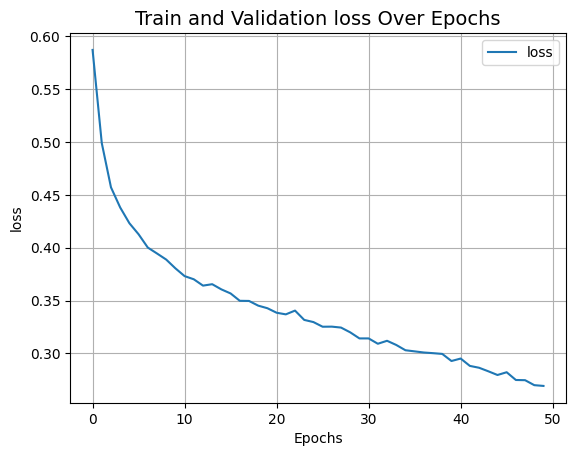

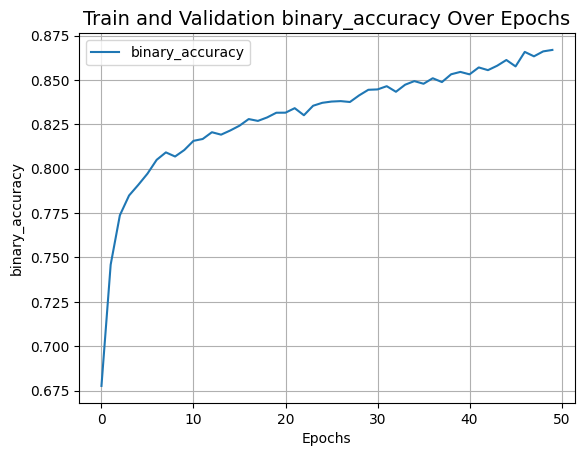

In [250]:
epochs = 50

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset,  epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")


In [251]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")


31/31 [==============================] - 0s 6ms/step - loss: 0.3972 - binary_accuracy: 0.8160
Categorical accuracy on the test set: 81.6%.
